## Define functions

In [20]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
import awkward as ak
import hist
import time
import vector

def create_histograms():
    histograms = {
        "hist_mu_pt": hist.Hist.new.Reg(150, 0, 500).Int64(),
        "hist_mumu_pt": hist.Hist.new.Reg(150, 0,500).Int64(),
        "hist_mumu_eta": hist.Hist.new.Reg(50, -5, 5).Int64(),
        "hist_mumu_deta": hist.Hist.new.Reg(150, -5, 5).Int64(),
        "hist_mumu_mass": hist.Hist.new.Reg(150, 0, 300).Int64(),
        "hist_b_pt": hist.Hist.new.Reg(150, 0, 500).Int64(),
        "hist_bb_pt": hist.Hist.new.Reg(150, 0, 500).Int64(),
        "hist_bb_eta": hist.Hist.new.Reg(50, -5, 5).Int64(),
        "hist_bb_deta": hist.Hist.new.Reg(150, -5, 5).Int64(),
        "hist_bb_mass": hist.Hist.new.Reg(150, 0, 300).Int64()
    }
    return histograms

def pt(px, py):
    return np.sqrt(px**2 + py**2)

def eta(px, py, pz, e):
    p = np.sqrt(px**2 + py**2 + pz**2)
    return 0.5 * np.log((e + pz) / (e - pz))

def mass(px, py, pz, e):
    return np.sqrt(e**2 - (px**2 + py**2 + pz**2))

def plot_hist(ax, hist_obj, xlabel, ylabel, title):
    edges = hist_obj.axes[0].edges
    values = hist_obj.values()
    ax.step(edges[:-1], values, where='post', alpha=0.7, label=title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend()
    ax.grid(True)
    

## Process Events

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
pt                   | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
eta                  | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
phi                  | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
mass                 | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
charge               | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
energy               | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
px                   | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
py                   | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
pz                   | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
pdgId                | std::vector<int32_t>     | AsJagged(AsDtype('>i4'), he...
status               | std::

/usr/local/lib/python3.9/site-packages/awkward/_nplikes/array_module.py:246: RuntimeWarning: divide by zero encountered in log
  return impl(*broadcasted_args, **(kwargs or {}))


b 1 pairs ---> [[-0.333, -0.333, -0.333, -0.333, ..., -0.333, -0.333, 0.333, -0.333], ...]
b 2 pairs ---> [[0.333, 0.333, 0.333, 0.333, 0.333, ..., 0.333, 0.333, -0.333, 0.333], ...]
Time to run: 1662.8536689281464 seconds


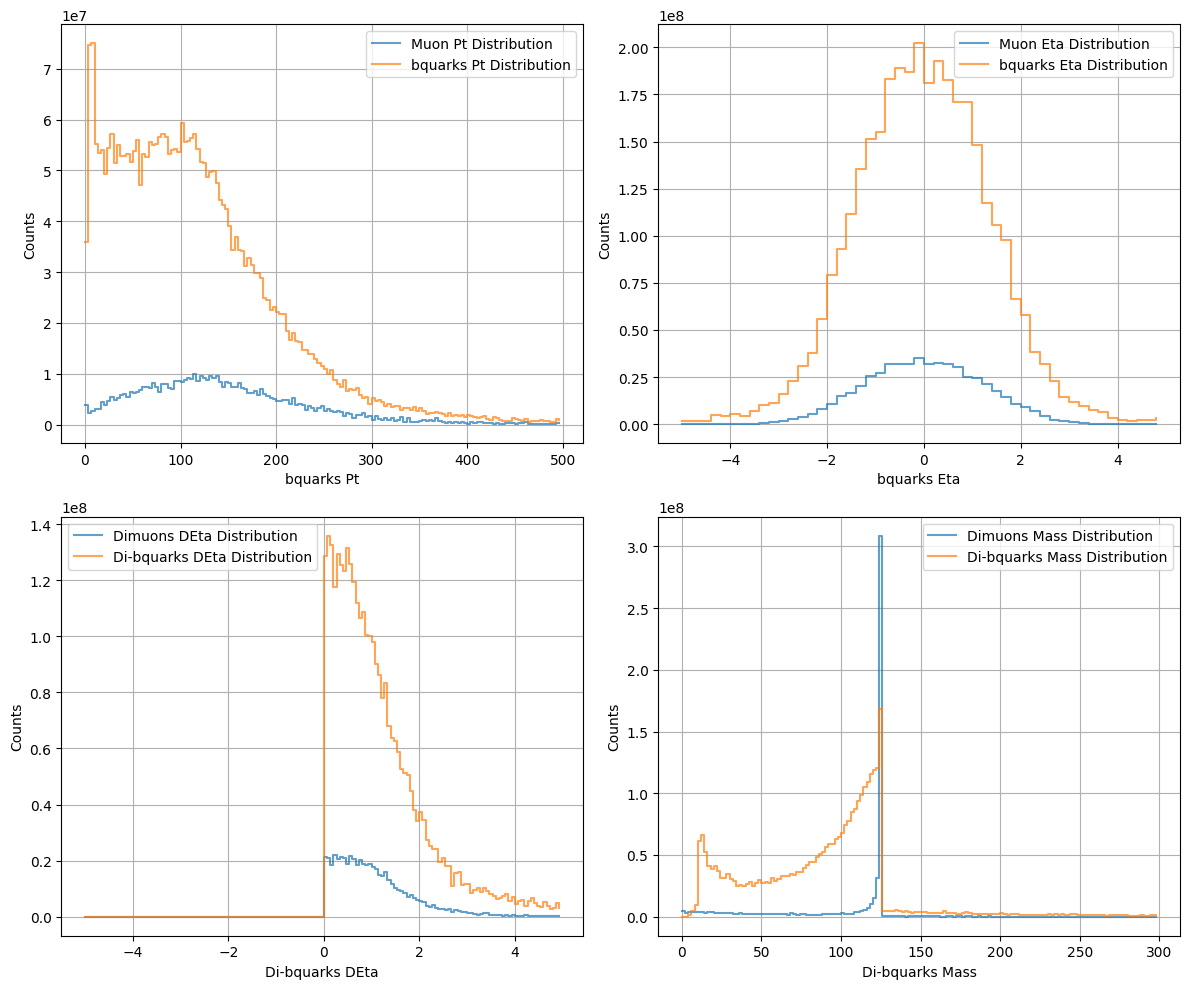

<Figure size 640x480 with 0 Axes>

In [18]:
start = time.time()
    
# Abrir o arquivo ROOT e verificar as keys
#file = uproot.open("pythia_events.root")
#print(file.keys())

# Transferir os eventos do arquivo para awkward arrays
#tree = file["events"]
#events= tree.arrays(library="ak")

# Get directly Root tree named Events
tree = uproot.open("events4.root")["Events"]
#print("Tree keys ---->" , tree.keys() )
tree.show()

# get Tree data into AWK arrays
events= tree.arrays(library="ak")

# Create the particles array collection in each event 
particles = ak.zip({"px": events.px, 
                    "py": events.py, 
                    "pz": events.pz, 
                    "e": events.energy, 
                    "pt": events.pt, 
                    "eta": events.eta, 
                    "phi": events.eta, 
                    "id": events.pdgId, 
                    "charge": events.charge,
                    "status": events.status}, 
                    with_name="particle")

print(" ")
print("Particles array:")
particles.type.show()



# Criar histogramas
histograms = create_histograms()

# Filtrar partículas
muons   = particles[ np.abs(particles.id) == 13 ]
bquarks = particles[np.abs(particles.id) == 5] 
print("muons status ---> ",muons.status)
print("bquarks status ---> ",bquarks.status)

if len(muons) >= 2:

    # Combinar muons com carga total = zero
    combs = ak.combinations(muons, 2,fields=["mu1","mu2"] )
    mupair = combs[ (combs["mu1"].charge + combs["mu2"].charge) == 0 ]
    print("mu 1 pairs --->", mupair["mu1"].charge)
    print("mu 2 pairs --->", mupair["mu2"].charge)

    for pair in mupair:
        pt_mumu  = pt( (mupair["mu1"].px + mupair["mu2"].px) , (mupair["mu1"].py + mupair["mu2"].py ))
        eta_mumu = eta((mupair["mu1"].px + mupair["mu2"].px) ,
                       (mupair["mu1"].py + mupair["mu2"].py) ,
                       (mupair["mu1"].pz + mupair["mu2"].pz) ,
                       (mupair["mu1"].e + mupair["mu2"].e) )
        
        deta_mumu = np.abs( mupair["mu1"].eta - mupair["mu2"].eta )
        mass_mumu = mass((mupair["mu1"].px + mupair["mu2"].px) ,
                         (mupair["mu1"].py + mupair["mu2"].py) ,
                         (mupair["mu1"].pz + mupair["mu2"].pz) ,
                         (mupair["mu1"].e + mupair["mu2"].e) )
        
        # Preencher histogramas
        histograms["hist_mumu_pt"].fill(ak.flatten(pt_mumu))
        histograms["hist_mumu_eta"].fill(ak.flatten(eta_mumu))
        histograms["hist_mumu_deta"].fill(ak.flatten(deta_mumu))
        histograms["hist_mumu_mass"].fill(ak.flatten(mass_mumu))
if len(muons) >= 2:

    # Combinar bquarks com carga total = zero
    combsb = ak.combinations(bquarks, 2,fields=["b1","b2"] )
    bquarkspair = combsb[ (combsb["b1"].charge + combsb["b2"].charge) == 0 ]
    print("b 1 pairs --->", bquarkspair["b1"].charge)
    print("b 2 pairs --->", bquarkspair["b2"].charge)

    for pairb in bquarkspair:
        pt_bb  = pt( (bquarkspair["b1"].px + bquarkspair["b2"].px) , (bquarkspair["b1"].py + bquarkspair["b2"].py ))
        eta_bb = eta((bquarkspair["b1"].px + bquarkspair["b2"].px) ,
                       (bquarkspair["b1"].py + bquarkspair["b2"].py) ,
                       (bquarkspair["b1"].pz + bquarkspair["b2"].pz) ,
                       (bquarkspair["b1"].e + bquarkspair["b2"].e) )
        
        deta_bb = np.abs( bquarkspair["b1"].eta - bquarkspair["b2"].eta )
        mass_bb = mass((bquarkspair["b1"].px + bquarkspair["b2"].px) ,
                         (bquarkspair["b1"].py + bquarkspair["b2"].py) ,
                         (bquarkspair["b1"].pz + bquarkspair["b2"].pz) ,
                         (bquarkspair["b1"].e + bquarkspair["b2"].e) )
        
        # Preencher histogramas
        histograms["hist_bb_pt"].fill(ak.flatten(pt_bb))
        histograms["hist_bb_eta"].fill(ak.flatten(eta_bb))
        histograms["hist_bb_deta"].fill(ak.flatten(deta_bb))
        histograms["hist_bb_mass"].fill(ak.flatten(mass_bb))

print(f"Time to run: {(time.time() - start)} seconds")

# Plotar os histogramas
fig, ax = plt.subplots(2, 2, figsize=(12, 10))

# Histogramas de muons
plot_hist(ax[0, 0], histograms["hist_mumu_pt"], 'Muons Pt', 'Counts', 'Muon Pt Distribution')
plot_hist(ax[0, 1], histograms["hist_mumu_eta"], 'Muons Eta', 'Counts', 'Muon Eta Distribution')
plot_hist(ax[1, 0], histograms["hist_mumu_deta"], 'Dimuons DEta', 'Counts', 'Dimuons DEta Distribution')
plot_hist(ax[1, 1], histograms["hist_mumu_mass"], 'Dimuons Mass', 'Counts', 'Dimuons Mass Distribution')
# Histogramas de bquarks
plot_hist(ax[0, 0], histograms["hist_bb_pt"], 'bquarks Pt', 'Counts', 'bquarks Pt Distribution')
plot_hist(ax[0, 1], histograms["hist_bb_eta"], 'bquarks Eta', 'Counts', 'bquarks Eta Distribution')
plot_hist(ax[1, 0], histograms["hist_bb_deta"], 'Di-bquarks DEta', 'Counts', 'Di-bquarks DEta Distribution')
plot_hist(ax[1, 1], histograms["hist_bb_mass"], 'Di-bquarks Mass', 'Counts', 'Di-bquarks Mass Distribution')


plt.tight_layout()
plt.show()


plt.tight_layout()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
pt                   | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
eta                  | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
phi                  | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
mass                 | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
charge               | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
energy               | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
px                   | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
py                   | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
pz                   | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
pdgId                | std::vector<int32_t>     | AsJagged(AsDtype('>i4'), he...
status               | std::

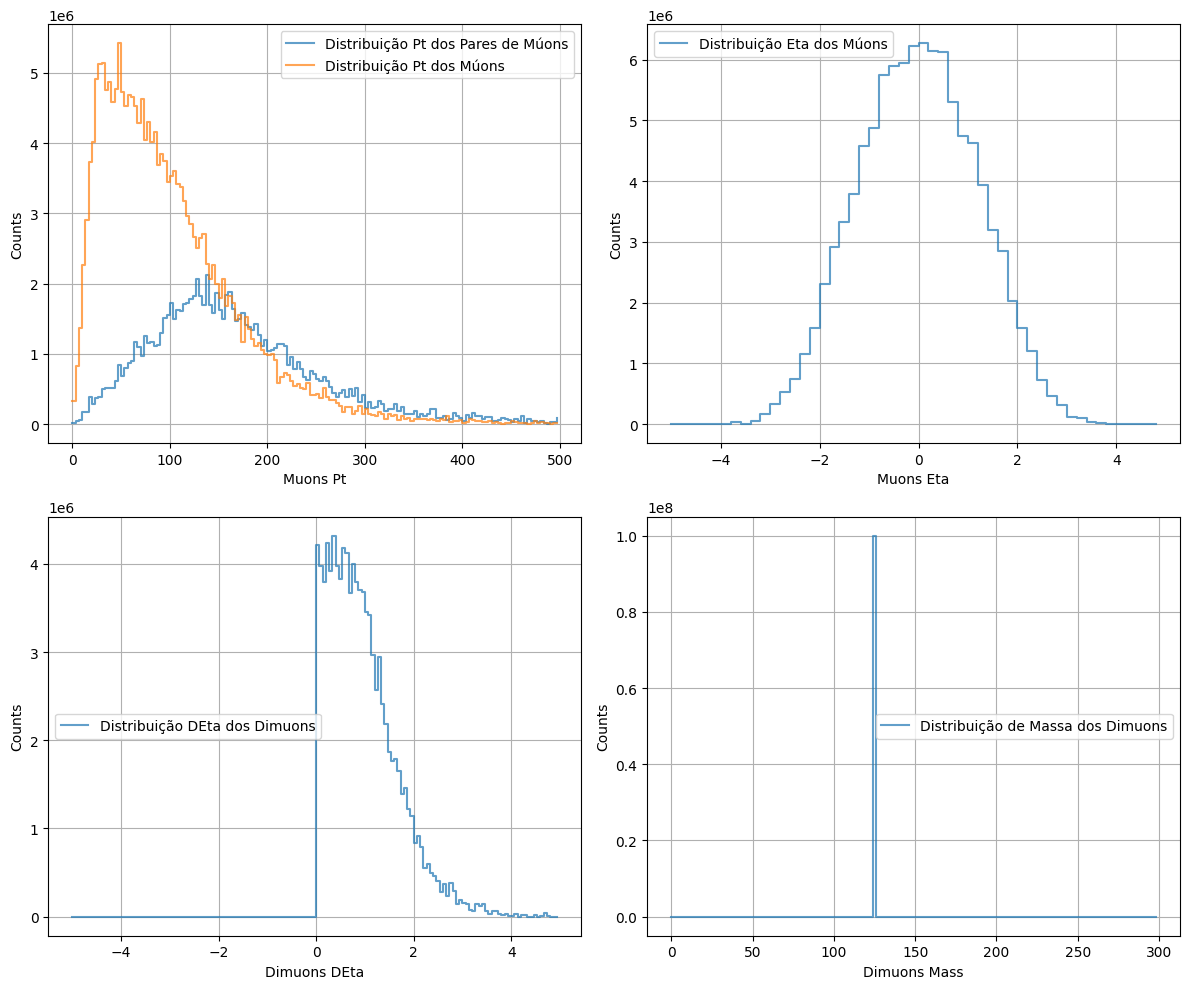

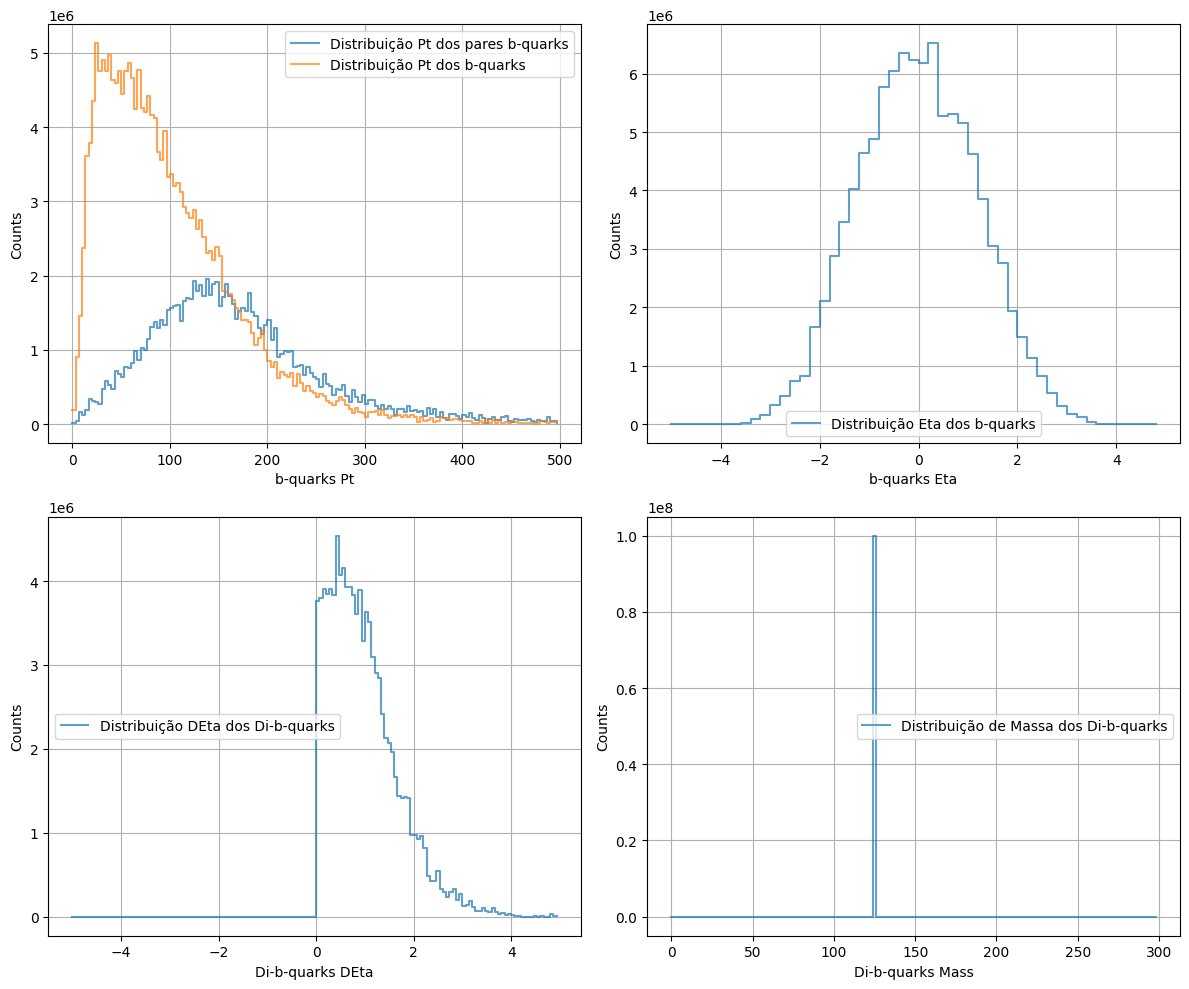

<Figure size 640x480 with 0 Axes>

In [17]:
start = time.time()
    
# Abrir o arquivo ROOT e verificar as keys
#file = uproot.open("pythia_events.root")
#print(file.keys())

# Transferir os eventos do arquivo para awkward arrays
#tree = file["events"]
#events= tree.arrays(library="ak")

# Get directly Root tree named Events
tree = uproot.open("events4.root")["Events"]
#print("Tree keys ---->" , tree.keys() )
tree.show()

# get Tree data into AWK arrays
events= tree.arrays(library="ak")

# Create the particles array collection in each event 

#p4 = vector.awk(px= events.px, py= events.py, pz= events.pz, E= events.energy )
particles = ak.zip({"px": events.px, 
                    "py": events.py, 
                    "pz": events.pz, 
                    "e": events.energy, 
                    "pt": events.pt, 
                    "eta": events.eta, 
                    "phi": events.eta, 
#                    "p4": p4,
                    "id": events.pdgId, 
                    "charge": events.charge,
                    "status": events.status}, 
                    with_name="particle")

print(" ")
print("Particles array:")
particles.type.show()



# Criar histogramas
histograms = create_histograms()

# Filtrar partículas
muons   = particles[ np.abs(particles.id) == 13 ]
bquarks = particles[np.abs(particles.id) == 5] 
print("muons status ---> ",muons.status)
print("bquarks status ---> ",bquarks.status)

muons_filtered = muons[(muons.status == 23) | (muons.status == -23)]

if len(muons) >= 2:
    pt_mu = pt(muons_filtered.px, muons_filtered.py)
    # Sort Pt
    print("Unsorted muons Pt : ", pt_mu)
    pt_mu = ak.sort(pt_mu, axis=-1, ascending=False)
    pt_mu = pt_mu[:,0:2]
    print("Sorted muons Pt : ", pt_mu)
    # Combinar muons com carga total = zero
    combs = ak.combinations(muons_filtered, 2,fields=["mu1","mu2"] )
    mupair = combs[ (combs["mu1"].charge + combs["mu2"].charge) == 0 ]
    print("mu 1 pairs --->", mupair["mu1"].charge)
    print("mu 2 pairs --->", mupair["mu2"].charge)

    for pair in mupair:
#        p4_dimu = mupair["mu1"].p4 + mupair["mu2"].p4 
#        pt_dimu = p4_dimu.pt
#        print("pt_dimu",pt_dimu)
        pt_mumu  = pt( (mupair["mu1"].px + mupair["mu2"].px) , (mupair["mu1"].py + mupair["mu2"].py ))
        eta_mumu = eta((mupair["mu1"].px + mupair["mu2"].px) ,
                       (mupair["mu1"].py + mupair["mu2"].py) ,
                       (mupair["mu1"].pz + mupair["mu2"].pz) ,
                       (mupair["mu1"].e + mupair["mu2"].e) )
        
        deta_mumu = np.abs( mupair["mu1"].eta - mupair["mu2"].eta )
        mass_mumu = mass((mupair["mu1"].px + mupair["mu2"].px) ,
                         (mupair["mu1"].py + mupair["mu2"].py) ,
                         (mupair["mu1"].pz + mupair["mu2"].pz) ,
                         (mupair["mu1"].e + mupair["mu2"].e) )
        
        # Preencher histogramas
        histograms["hist_mu_pt"].fill(ak.flatten(pt_mu))
        histograms["hist_mumu_pt"].fill(ak.flatten(pt_mumu))
        histograms["hist_mumu_eta"].fill(ak.flatten(eta_mumu))
        histograms["hist_mumu_deta"].fill(ak.flatten(deta_mumu))
        histograms["hist_mumu_mass"].fill(ak.flatten(mass_mumu))

bquark_filtered = bquarks[(bquarks.status == 23) | (bquarks.status == -23)]
if len(muons) >= 2:

    pt_b = pt(bquark_filtered.px, bquark_filtered.py)
    # Combinar bquarks com carga total = zero
    combsb = ak.combinations(bquark_filtered, 2,fields=["b1","b2"] )
    bquarkspair = combsb[ (combsb["b1"].charge + combsb["b2"].charge) == 0 ]
    print("b 1 pairs --->", bquarkspair["b1"].charge)
    print("b 2 pairs --->", bquarkspair["b2"].charge)

    for pairb in bquarkspair:
        pt_bb  = pt( (bquarkspair["b1"].px + bquarkspair["b2"].px) , (bquarkspair["b1"].py + bquarkspair["b2"].py ))
        eta_bb = eta((bquarkspair["b1"].px + bquarkspair["b2"].px) ,
                       (bquarkspair["b1"].py + bquarkspair["b2"].py) ,
                       (bquarkspair["b1"].pz + bquarkspair["b2"].pz) ,
                       (bquarkspair["b1"].e + bquarkspair["b2"].e) )
        
        deta_bb = np.abs( bquarkspair["b1"].eta - bquarkspair["b2"].eta )
        mass_bb = mass((bquarkspair["b1"].px + bquarkspair["b2"].px) ,
                         (bquarkspair["b1"].py + bquarkspair["b2"].py) ,
                         (bquarkspair["b1"].pz + bquarkspair["b2"].pz) ,
                         (bquarkspair["b1"].e + bquarkspair["b2"].e) )
        
        # Preencher histogramas
        histograms["hist_bb_pt"].fill(ak.flatten(pt_bb))
        histograms["hist_b_pt"].fill(ak.flatten(pt_b))
        histograms["hist_bb_eta"].fill(ak.flatten(eta_bb))
        histograms["hist_bb_deta"].fill(ak.flatten(deta_bb))
        histograms["hist_bb_mass"].fill(ak.flatten(mass_bb))

print(f"Time to run: {(time.time() - start)} seconds")

# Plotar os histogramas
fig, ax = plt.subplots(2, 2, figsize=(12, 10))

# Histogramas de múons
#ax[0, 0].set_xlim(0, 200)
plot_hist(ax[0, 0], histograms["hist_mumu_pt"], '2Muons Pt', 'Counts', 'Distribuição Pt dos Pares de Múons')
plot_hist(ax[0, 0], histograms["hist_mu_pt"], 'Muons Pt', 'Counts', 'Distribuição Pt dos Múons')
plot_hist(ax[0, 1], histograms["hist_mumu_eta"], 'Muons Eta', 'Counts', 'Distribuição Eta dos Múons')
plot_hist(ax[1, 0], histograms["hist_mumu_deta"], 'Dimuons DEta', 'Counts', 'Distribuição DEta dos Dimuons')
plot_hist(ax[1, 1], histograms["hist_mumu_mass"], 'Dimuons Mass', 'Counts', 'Distribuição de Massa dos Dimuons')

plt.tight_layout()
plt.show()

# Histogramas de b-quarks
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
#ax[0, 0].set_xlim(0, 200)
plot_hist(ax[0, 0], histograms["hist_bb_pt"], '2b-quarks Pt', 'Counts', 'Distribuição Pt dos pares b-quarks')
plot_hist(ax[0, 0], histograms["hist_b_pt"], 'b-quarks Pt', 'Counts', 'Distribuição Pt dos b-quarks')
plot_hist(ax[0, 1], histograms["hist_bb_eta"], 'b-quarks Eta', 'Counts', 'Distribuição Eta dos b-quarks')
plot_hist(ax[1, 0], histograms["hist_bb_deta"], 'Di-b-quarks DEta', 'Counts', 'Distribuição DEta dos Di-b-quarks')
plot_hist(ax[1, 1], histograms["hist_bb_mass"], 'Di-b-quarks Mass', 'Counts', 'Distribuição de Massa dos Di-b-quarks')

plt.tight_layout()
plt.show()


plt.tight_layout()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
pt                   | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
eta                  | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
phi                  | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
mass                 | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
charge               | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
energy               | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
px                   | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
py                   | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
pz                   | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
pdgId                | std::vector<int32_t>     | AsJagged(AsDtype('>i4'), he...
status               | std::

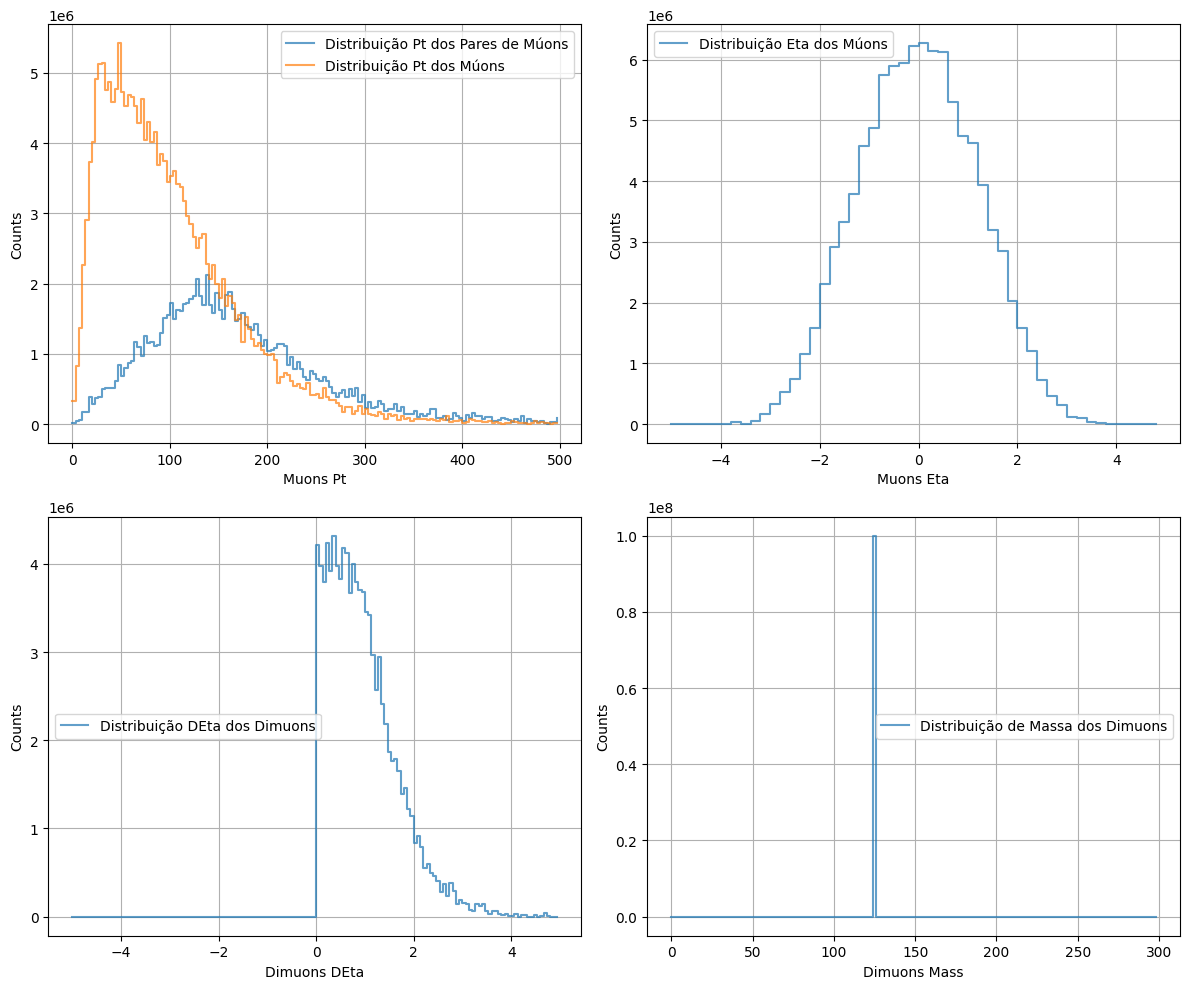

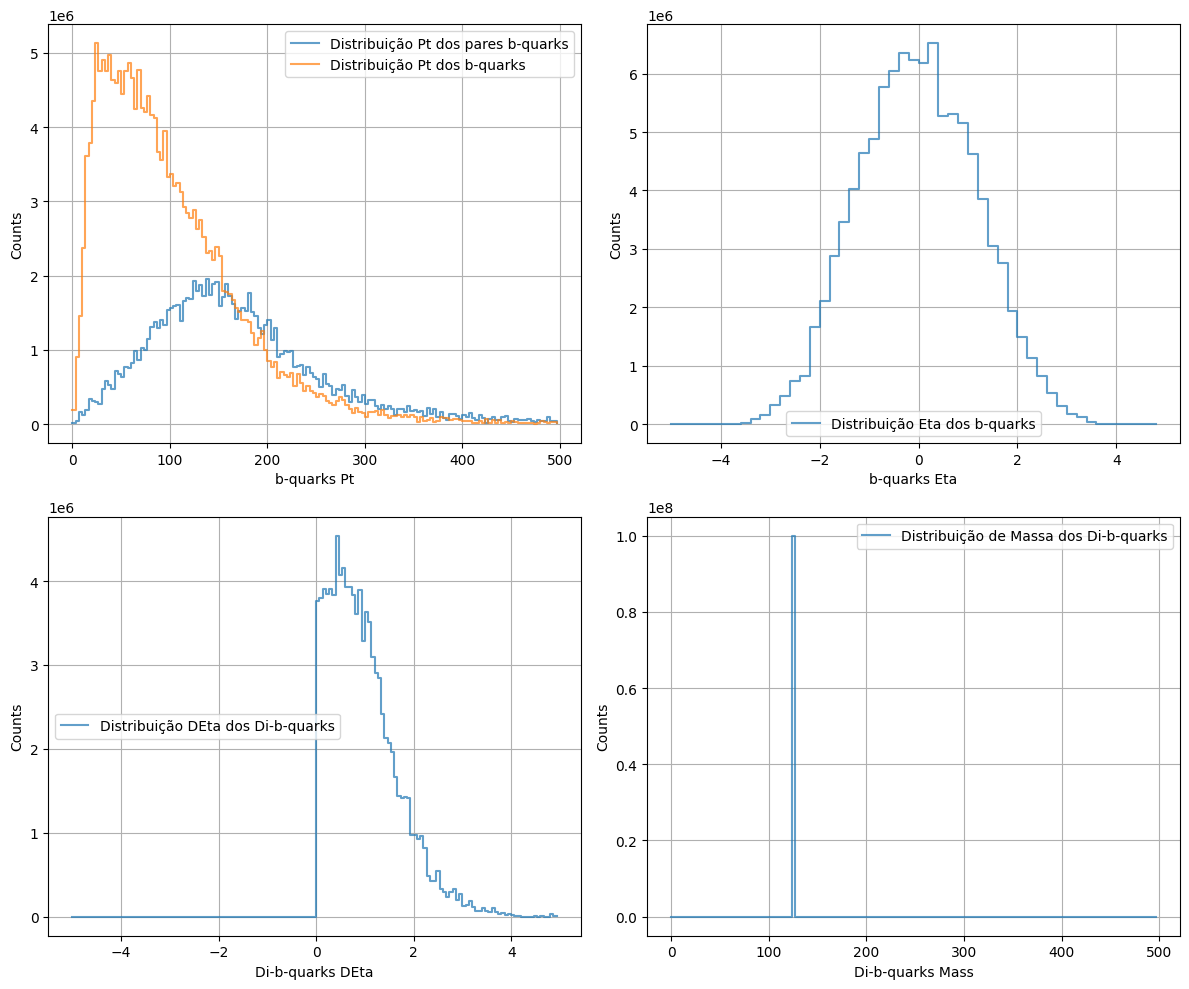

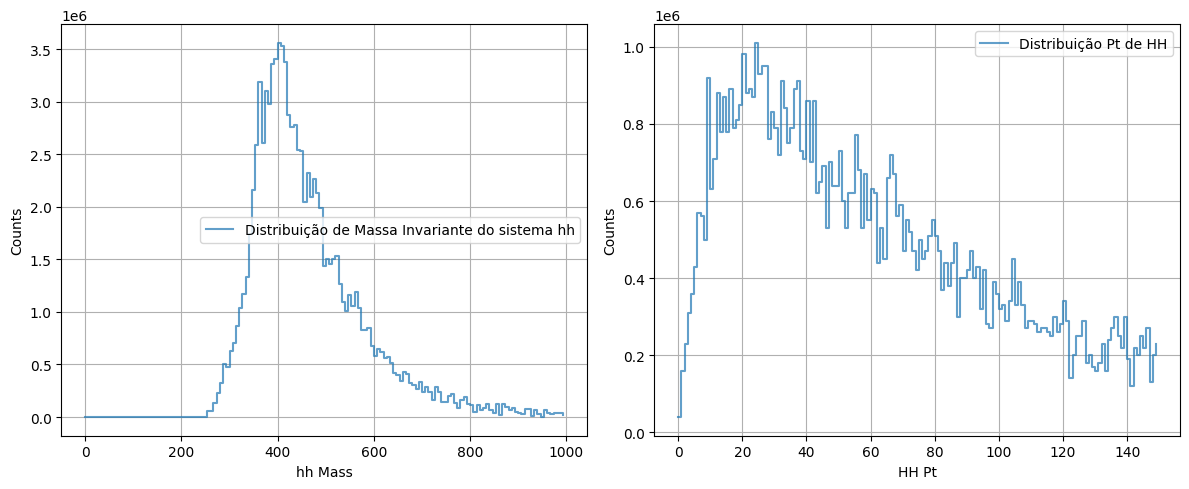

In [19]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
import awkward as ak
import hist
import time

def create_histograms():
    histograms = {
        "hist_mu_pt": hist.Hist.new.Reg(150, 0, 500).Int64(),
        "hist_mumu_pt": hist.Hist.new.Reg(150, 0, 500).Int64(),
        "hist_mumu_eta": hist.Hist.new.Reg(50, -5, 5).Int64(),
        "hist_mumu_deta": hist.Hist.new.Reg(150, -5, 5).Int64(),
        "hist_mumu_mass": hist.Hist.new.Reg(150, 0, 300).Int64(),
        "hist_b_pt": hist.Hist.new.Reg(150, 0, 500).Int64(),
        "hist_bb_pt": hist.Hist.new.Reg(150, 0, 500).Int64(),
        "hist_bb_eta": hist.Hist.new.Reg(50, -5, 5).Int64(),
        "hist_bb_deta": hist.Hist.new.Reg(150, -5, 5).Int64(),
        "hist_bb_mass": hist.Hist.new.Reg(150, 0, 500).Int64(),
        "hist_hh_mass": hist.Hist.new.Reg(150, 0, 1000).Int64(),  # Massa invariante do sistema hh
        "hist_hh_pt": hist.Hist.new.Reg(150, 0, 150).Int64()  # pT dos Higgs
    }
    return histograms

def pt(px, py):
    return np.sqrt(px**2 + py**2)

def eta(px, py, pz, e):
    p = np.sqrt(px**2 + py**2 + pz**2)
    return 0.5 * np.log((e + pz) / (e - pz))

def mass(px, py, pz, e):
    return np.sqrt(e**2 - (px**2 + py**2 + pz**2))

def plot_hist(ax, hist_obj, xlabel, ylabel, title):
    edges = hist_obj.axes[0].edges
    values = hist_obj.values()
    ax.step(edges[:-1], values, where='post', alpha=0.7, label=title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend()
    ax.grid(True)

# Abrir o arquivo ROOT
tree = uproot.open("events4.root")["Events"]
tree.show()

# Transferir os eventos do arquivo para awkward arrays
events = tree.arrays(library="ak")

# Criar a coleção de partículas
particles = ak.zip({"px": events.px, 
                    "py": events.py, 
                    "pz": events.pz, 
                    "e": events.energy, 
                    "pt": events.pt, 
                    "eta": events.eta, 
                    "phi": events.phi, 
                    "id": events.pdgId, 
                    "charge": events.charge,
                    "status": events.status}, 
                    with_name="particle")

print("Particles array:")
particles.type.show()

# Criar histogramas
histograms = create_histograms()

# Filtrar partículas
muons = particles[np.abs(particles.id) == 13]
bquarks = particles[np.abs(particles.id) == 5] 

muons_filtered = muons[(muons.status == 23) | (muons.status == -23)]
bquark_filtered = bquarks[(bquarks.status == 23) | (bquarks.status == -23)]

# Para muons
if len(muons) >= 2:
    pt_mu = pt(muons_filtered.px, muons_filtered.py)
    combs = ak.combinations(muons_filtered, 2, fields=["mu1", "mu2"])
    mupair = combs[(combs["mu1"].charge + combs["mu2"].charge) == 0]

    for pair in mupair:
        pt_mumu = pt((mupair["mu1"].px + mupair["mu2"].px), 
                      (mupair["mu1"].py + mupair["mu2"].py))
        eta_mumu = eta((mupair["mu1"].px + mupair["mu2"].px), 
                        (mupair["mu1"].py + mupair["mu2"].py), 
                        (mupair["mu1"].pz + mupair["mu2"].pz), 
                        (mupair["mu1"].e + mupair["mu2"].e))
        
        deta_mumu = np.abs(mupair["mu1"].eta - mupair["mu2"].eta)
        mass_mumu = mass((mupair["mu1"].px + mupair["mu2"].px), 
                         (mupair["mu1"].py + mupair["mu2"].py), 
                         (mupair["mu1"].pz + mupair["mu2"].pz), 
                         (mupair["mu1"].e + mupair["mu2"].e))
        
        # Preencher histogramas
        histograms["hist_mu_pt"].fill(ak.flatten(pt_mu))
        histograms["hist_mumu_pt"].fill(ak.flatten(pt_mumu))
        histograms["hist_mumu_eta"].fill(ak.flatten(eta_mumu))
        histograms["hist_mumu_deta"].fill(ak.flatten(deta_mumu))
        histograms["hist_mumu_mass"].fill(ak.flatten(mass_mumu))

# Para b-quarks
if len(bquarks) >= 2:
    pt_b = pt(bquark_filtered.px, bquark_filtered.py)
    combsb = ak.combinations(bquark_filtered, 2, fields=["b1", "b2"])
    bquarkspair = combsb[(combsb["b1"].charge + combsb["b2"].charge) == 0]

    for pairb in bquarkspair:
        pt_bb = pt((bquarkspair["b1"].px + bquarkspair["b2"].px), 
                    (bquarkspair["b1"].py + bquarkspair["b2"].py))
        eta_bb = eta((bquarkspair["b1"].px + bquarkspair["b2"].px), 
                      (bquarkspair["b1"].py + bquarkspair["b2"].py), 
                      (bquarkspair["b1"].pz + bquarkspair["b2"].pz), 
                      (bquarkspair["b1"].e + bquarkspair["b2"].e))
        
        deta_bb = np.abs(bquarkspair["b1"].eta - bquarkspair["b2"].eta)
        mass_bb = mass((bquarkspair["b1"].px + bquarkspair["b2"].px), 
                        (bquarkspair["b1"].py + bquarkspair["b2"].py), 
                        (bquarkspair["b1"].pz + bquarkspair["b2"].pz), 
                        (bquarkspair["b1"].e + bquarkspair["b2"].e))
        
        # Preencher histogramas
        histograms["hist_bb_pt"].fill(ak.flatten(pt_bb))
        histograms["hist_b_pt"].fill(ak.flatten(pt_b))
        histograms["hist_bb_eta"].fill(ak.flatten(eta_bb))
        histograms["hist_bb_deta"].fill(ak.flatten(deta_bb))
        histograms["hist_bb_mass"].fill(ak.flatten(mass_bb))

        # Calcular a massa invariante do sistema hh
        total_px = mupair["mu1"].px + mupair["mu2"].px + bquarkspair["b1"].px + bquarkspair["b2"].px
        total_py = mupair["mu1"].py + mupair["mu2"].py + bquarkspair["b1"].py + bquarkspair["b2"].py
        total_pz = mupair["mu1"].pz + mupair["mu2"].pz + bquarkspair["b1"].pz + bquarkspair["b2"].pz
        total_e = mupair["mu1"].e + mupair["mu2"].e + bquarkspair["b1"].e + bquarkspair["b2"].e
        
        mass_hh = mass(total_px, total_py, total_pz, total_e)
        histograms["hist_hh_mass"].fill(ak.flatten(mass_hh))
        # Calcular pT do sistema HH
        pt_hh = pt(total_px, total_py)
        histograms["hist_hh_pt"].fill(ak.flatten(pt_hh))

# Print time taken
print(f"Time to run: {(time.time() - start)} seconds")

# Plotar os histogramas
fig, ax = plt.subplots(2, 2, figsize=(12, 10))

# Histogramas de múons

plot_hist(ax[0, 0], histograms["hist_mumu_pt"], '2Muons Pt', 'Counts', 'Distribuição Pt dos Pares de Múons')
plot_hist(ax[0, 0], histograms["hist_mu_pt"], 'Muons Pt', 'Counts', 'Distribuição Pt dos Múons')
plot_hist(ax[0, 1], histograms["hist_mumu_eta"], 'Muons Eta', 'Counts', 'Distribuição Eta dos Múons')
plot_hist(ax[1, 0], histograms["hist_mumu_deta"], 'Dimuons DEta', 'Counts', 'Distribuição DEta dos Dimuons')
plot_hist(ax[1, 1], histograms["hist_mumu_mass"], 'Dimuons Mass', 'Counts', 'Distribuição de Massa dos Dimuons')

plt.tight_layout()
plt.show()

# Histogramas de b-quarks
fig, ax = plt.subplots(2, 2, figsize=(12, 10))

plot_hist(ax[0, 0], histograms["hist_bb_pt"], '2b-quarks Pt', 'Counts', 'Distribuição Pt dos pares b-quarks')
plot_hist(ax[0, 0], histograms["hist_b_pt"], 'b-quarks Pt', 'Counts', 'Distribuição Pt dos b-quarks')
plot_hist(ax[0, 1], histograms["hist_bb_eta"], 'b-quarks Eta', 'Counts', 'Distribuição Eta dos b-quarks')
plot_hist(ax[1, 0], histograms["hist_bb_deta"], 'Di-b-quarks DEta', 'Counts', 'Distribuição DEta dos Di-b-quarks')
plot_hist(ax[1, 1], histograms["hist_bb_mass"], 'Di-b-quarks Mass', 'Counts', 'Distribuição de Massa dos Di-b-quarks')

plt.tight_layout()
plt.show()

# Histogramas dos Higgs
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
plot_hist(ax[0], histograms["hist_hh_mass"], 'hh Mass', 'Counts', 'Distribuição de Massa Invariante do sistema hh')
plot_hist(ax[1], histograms["hist_hh_pt"], 'HH Pt', 'Counts', 'Distribuição Pt de HH')

plt.tight_layout()
plt.show()


In [2]:
import uproot 
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt

# Função para extrair todas as partículas
def extract_all_particles(events):
    particles = ak.zip({"px": events.px, 
                    "py": events.py, 
                    "pz": events.pz, 
                    "e": events.energy, 
                    "pt": events.pt, 
                    "eta": events.eta, 
                    "phi": events.phi, 
                    "id": events.pdgId, 
                    "charge": events.charge,
                    "status": events.status}, 
                    with_name="particle")
    
    return particles

# Abrir o arquivo ROOT
tree = uproot.open("events4.root")["Events"]

# Transferir os eventos do arquivo para awkward arrays
events = tree.arrays(library="ak")

# Extrair todas as partículas
all_particles = extract_all_particles(events)

# Extraindo IDs de todas as partículas
all_ids = ak.flatten(all_particles.id)

# Garantindo que all_ids seja um array numpy
all_ids = ak.to_numpy(all_ids)
all_ids = all_ids[~np.isnan(all_ids)]  # Removendo NaNs se houver

# Contar a quantidade de cada ID
unique_ids, counts = np.unique(all_ids, return_counts=True)

# Exibir os resultados
print("ID | Quantidade")
print("----------------")
for unique_id, count in zip(unique_ids, counts):
    print(f"{unique_id:>2} | {count}")




ID | Quantidade
----------------
-30313 | 1
-20433 | 133
-20423 | 102
-20413 | 109
-20313 | 249
-20213 | 1384
-14122 | 10
-10433 | 15
-10431 | 33
-10423 | 73
-10421 | 59
-10413 | 90
-10411 | 46
-10323 | 143
-10321 | 28
-10313 | 106
-10311 | 80
-5324 | 4
-5322 | 4
-5314 | 5
-5312 | 8
-5232 | 65
-5224 | 29
-5222 | 13
-5214 | 30
-5212 | 11
-5132 | 47
-5122 | 378
-5114 | 33
-5112 | 9
-4334 | 5
-4332 | 11
-4324 | 17
-4322 | 14
-4314 | 15
-4312 | 14
-4232 | 78
-4224 | 19
-4222 | 37
-4214 | 44
-4212 | 50
-4132 | 90
-4124 | 7
-4122 | 743
-4114 | 48
-4112 | 58
-3334 | 58
-3324 | 302
-3322 | 1714
-3314 | 265
-3312 | 1654
-3224 | 1603
-3222 | 6373
-3214 | 1607
-3212 | 6622
-3122 | 21453
-3114 | 1459
-3112 | 6081
-2224 | 8187
-2214 | 8327
-2212 | 67012
-2114 | 8193
-2112 | 66795
-1114 | 7937
-543 | 2
-541 | 3
-533 | 775
-531 | 1114
-523 | 3207
-521 | 4672
-513 | 3183
-511 | 4659
-435 | 19
-433 | 1556
-431 | 2772
-425 | 97
-423 | 3922
-421 | 10057
-415 | 67
-413 | 3891
-411 | 4939
-325 | 30
-323 | 

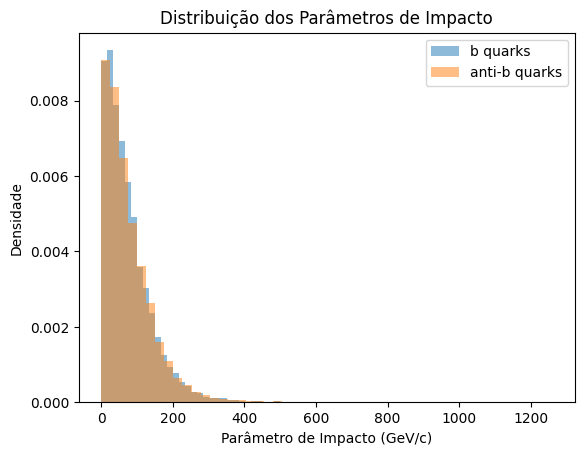

In [6]:
import uproot 
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt

# Função para extrair todas as partículas
def extract_all_particles(events):
    particles = ak.zip({"px": events.px, 
                        "py": events.py, 
                        "pz": events.pz, 
                        "id": events.pdgId}, 
                       with_name="particle")
    return particles

# Função para calcular a distância de impacto
def calculate_impact_parameter(particles):
    # Distância de impacto no plano transverso (xy)
    return np.sqrt(particles.px**2 + particles.py**2)

# Abrir o arquivo ROOT
tree = uproot.open("events4.root")["Events"]

# Transferir os eventos do arquivo para awkward arrays
events = tree.arrays(library="ak")

# Extrair todas as partículas
all_particles = extract_all_particles(events)

# Filtrando partículas b e anti-b
b_particles = all_particles[all_particles.id == 5]  # ID para b quark
bbar_particles = all_particles[all_particles.id == -5]  # ID para anti-b quark

# Calcular parâmetros de impacto e garantir que sejam arrays 1D
b_impact_params = ak.flatten(calculate_impact_parameter(b_particles))
bbar_impact_params = ak.flatten(calculate_impact_parameter(bbar_particles))

# Converter para numpy arrays
b_impact_params = ak.to_numpy(b_impact_params, allow_missing=True)
bbar_impact_params = ak.to_numpy(bbar_impact_params, allow_missing=True)

# Remover NaNs se houver
b_impact_params = b_impact_params[~np.isnan(b_impact_params)]
bbar_impact_params = bbar_impact_params[~np.isnan(bbar_impact_params)]

# Plotar a distribuição dos parâmetros de impacto
plt.hist(b_impact_params, bins=50, alpha=0.5, label='b quarks', density=True)
plt.hist(bbar_impact_params, bins=50, alpha=0.5, label='anti-b quarks', density=True)
plt.xlabel('Parâmetro de Impacto (GeV/c)')
plt.ylabel('Densidade')
plt.title('Distribuição dos Parâmetros de Impacto')
plt.legend()
plt.show()


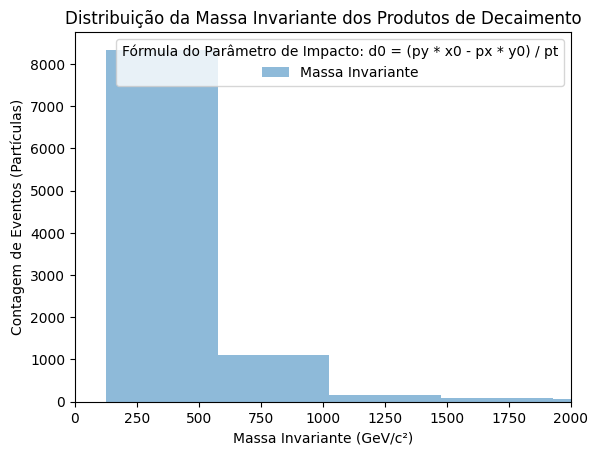

In [16]:
import uproot
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt

# Função para extrair todas as partículas
def extract_all_particles(events):
    return ak.zip({"px": events.px, 
                   "py": events.py, 
                   "pz": events.pz, 
                   "e": events.energy, 
                   "id": events.pdgId}, 
                  with_name="particle")

# Função para calcular o parâmetro de impacto
def calculate_impact_parameter(particles, interaction_point=(0, 0)):
    x0, y0 = interaction_point
    pt = np.sqrt(particles.px**2 + particles.py**2)  
    # Evitar divisão por zero
    pt = ak.where(pt == 0, 1e-10, pt)
    d0 = (particles.py * x0 - particles.px * y0) / pt
    return d0

# Abrir o arquivo ROOT
tree = uproot.open("events4.root")["Events"]
events = tree.arrays(library="ak")

# Extrair todas as partículas
all_particles = extract_all_particles(events)

# Calcular parâmetros de impacto para partículas
impact_params = calculate_impact_parameter(all_particles)

# Filtrar partículas com base nos parâmetros de impacto
filtered_particles = all_particles[np.abs(impact_params) < 1.0]

# Filtrar produtos de decaimento do quark b
decay_products = filtered_particles[(filtered_particles.id == 5) | (filtered_particles.id == -5)]

# Função para calcular a massa invariante
def invariant_mass(particles):
    energy = ak.sum(particles.e, axis=1)
    px = ak.sum(particles.px, axis=1)
    py = ak.sum(particles.py, axis=1)
    pz = ak.sum(particles.pz, axis=1)
    
    return np.sqrt(energy**2 - px**2 - py**2 - pz**2)  

# Calcular a massa invariante
mass = invariant_mass(decay_products)

# Plotar a distribuição das massas invariantes
plt.hist(mass, bins=50, alpha=0.5, label='Massa Invariante', density=False)
plt.xlabel('Massa Invariante (GeV/c²)')
plt.ylabel('Contagem de Eventos (Partículas)')
plt.title('Distribuição da Massa Invariante dos Produtos de Decaimento')
plt.xlim(0, 2000)  # Ajustando o limite do eixo X
plt.legend(title='Fórmula do Parâmetro de Impacto: d0 = (py * x0 - px * y0) / pt')
plt.show()


## Process Events others

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
id                   | std::vector<int32_t>     | AsJagged(AsDtype('>i4'), he...
px                   | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
py                   | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
pz                   | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
e                    | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
id                   | std::vector<int32_t>     | AsJagged(AsDtype('>i4'), he...
pt                   | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
eta                  | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
 
Particles array:
1000 * var * particle[
    px: float32,
    py: float32,
    pz: float32,
    e: float32,
    pt: float32,
    eta: float32,
    id: int32,
    charge: int32
]
muons charg

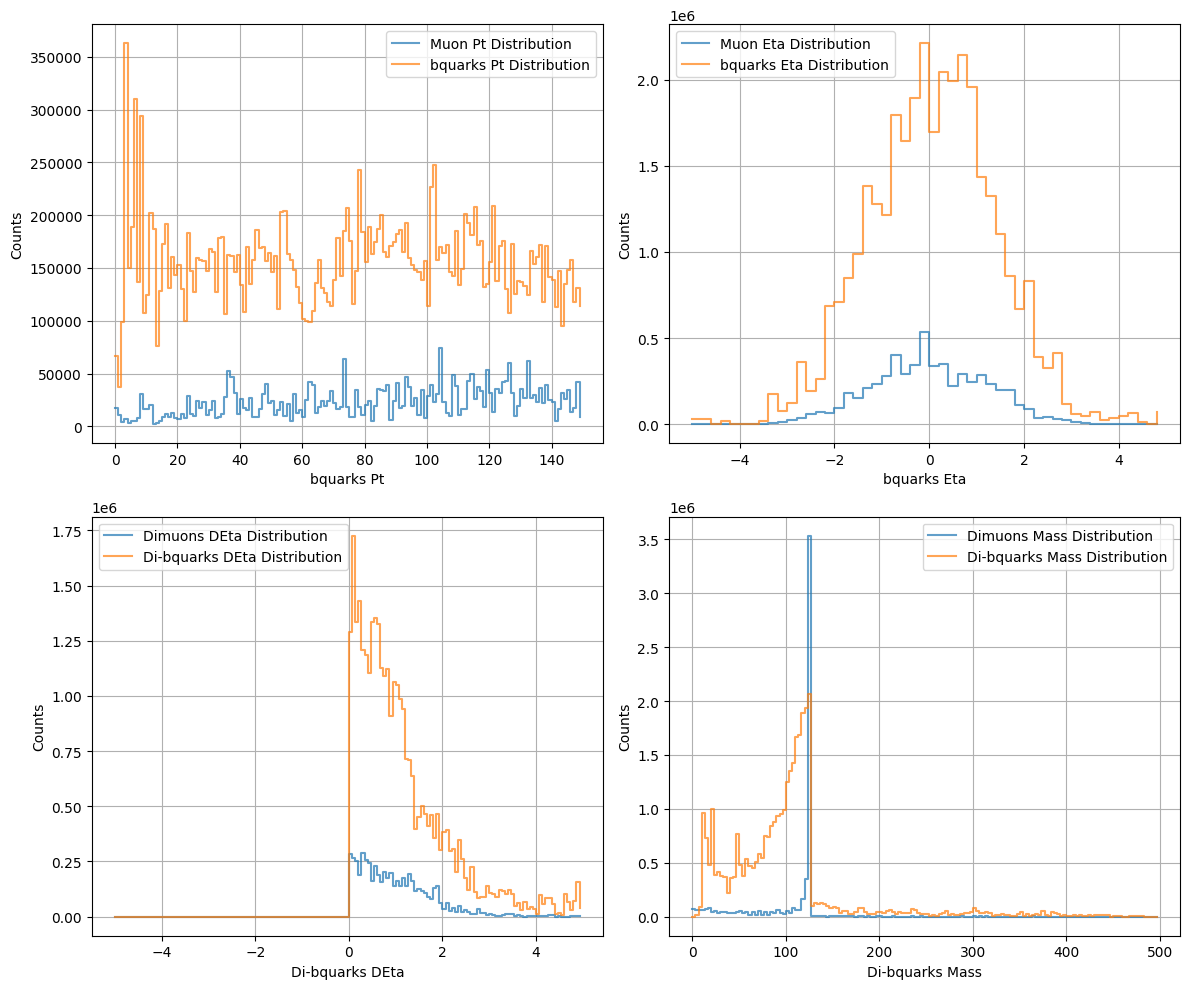

<Figure size 640x480 with 0 Axes>

In [53]:
start = time.time()
    
# Abrir o arquivo ROOT e verificar as keys
#file = uproot.open("pythia_events.root")
#print(file.keys())

# Transferir os eventos do arquivo para awkward arrays
#tree = file["events"]
#events= tree.arrays(library="ak")

# Get directly Root tree named Events
tree = uproot.open("pythia_events.root")["events"]
#print("Tree keys ---->" , tree.keys() )
tree.show()

# get Tree data into AWK arrays
events= tree.arrays(library="ak")

# Create the particles array collection in each event 
particles = ak.zip({"px": events.px, 
                    "py": events.py, 
                    "pz": events.pz, 
                    "e": events.e, 
                    "pt": events.pt, 
                    "eta": events.eta, 
                    #"phi": events.eta, 
                    "id": events.id, 
                    "charge": np.sign(events.id),
                    }, 
                    with_name="particle")

print(" ")
print("Particles array:")
particles.type.show()



# Criar histogramas
histograms = create_histograms()

# Filtrar partículas
muons   = particles[np.abs(particles.id) == 13]
bquarks = particles[np.abs(particles.id) == 5] 
print("muons charge ---> ",muons.charge)
print("bquarks charge ---> ",bquarks.charge)

if len(muons) >= 2:

    # Combinar muons com carga total = zero
    combs = ak.combinations(muons, 2,fields=["mu1","mu2"] )
    mupair = combs[ (combs["mu1"].charge + combs["mu2"].charge) == 0 ]
    print("mu 1 pairs --->", mupair["mu1"].charge)
    print("mu 2 pairs --->", mupair["mu2"].charge)

    for pair in mupair:
        pt_mumu  = pt( (mupair["mu1"].px + mupair["mu2"].px) , (mupair["mu1"].py + mupair["mu2"].py ))
        eta_mumu = eta((mupair["mu1"].px + mupair["mu2"].px) ,
                       (mupair["mu1"].py + mupair["mu2"].py) ,
                       (mupair["mu1"].pz + mupair["mu2"].pz) ,
                       (mupair["mu1"].e + mupair["mu2"].e) )
        
        deta_mumu = np.abs( mupair["mu1"].eta - mupair["mu2"].eta )
        mass_mumu = mass((mupair["mu1"].px + mupair["mu2"].px) ,
                         (mupair["mu1"].py + mupair["mu2"].py) ,
                         (mupair["mu1"].pz + mupair["mu2"].pz) ,
                         (mupair["mu1"].e + mupair["mu2"].e) )
        
        # Preencher histogramas
        histograms["hist_mumu_pt"].fill(ak.flatten(pt_mumu))
        histograms["hist_mumu_eta"].fill(ak.flatten(eta_mumu))
        histograms["hist_mumu_deta"].fill(ak.flatten(deta_mumu))
        histograms["hist_mumu_mass"].fill(ak.flatten(mass_mumu))
if len(muons) >= 2:

    # Combinar bquarks com carga total = zero
    combsb = ak.combinations(bquarks, 2,fields=["b1","b2"] )
    bquarkspair = combsb[ (combsb["b1"].charge + combsb["b2"].charge) == 0 ]
    print("b 1 pairs --->", bquarkspair["b1"].charge)
    print("b 2 pairs --->", bquarkspair["b2"].charge)

    for pairb in bquarkspair:
        pt_bb  = pt( (bquarkspair["b1"].px + bquarkspair["b2"].px) , (bquarkspair["b1"].py + bquarkspair["b2"].py ))
        eta_bb = eta((bquarkspair["b1"].px + bquarkspair["b2"].px) ,
                       (bquarkspair["b1"].py + bquarkspair["b2"].py) ,
                       (bquarkspair["b1"].pz + bquarkspair["b2"].pz) ,
                       (bquarkspair["b1"].e + bquarkspair["b2"].e) )
        
        deta_bb = np.abs( bquarkspair["b1"].eta - bquarkspair["b2"].eta )
        mass_bb = mass((bquarkspair["b1"].px + bquarkspair["b2"].px) ,
                         (bquarkspair["b1"].py + bquarkspair["b2"].py) ,
                         (bquarkspair["b1"].pz + bquarkspair["b2"].pz) ,
                         (bquarkspair["b1"].e + bquarkspair["b2"].e) )
        
        # Preencher histogramas
        histograms["hist_bb_pt"].fill(ak.flatten(pt_bb))
        histograms["hist_bb_eta"].fill(ak.flatten(eta_bb))
        histograms["hist_bb_deta"].fill(ak.flatten(deta_bb))
        histograms["hist_bb_mass"].fill(ak.flatten(mass_bb))

print(f"Time to run: {(time.time() - start)} seconds")

# Plotar os histogramas
fig, ax = plt.subplots(2, 2, figsize=(12, 10))

# Histogramas de muons
plot_hist(ax[0, 0], histograms["hist_mumu_pt"], 'Muons Pt', 'Counts', 'Muon Pt Distribution')
plot_hist(ax[0, 1], histograms["hist_mumu_eta"], 'Muons Eta', 'Counts', 'Muon Eta Distribution')
plot_hist(ax[1, 0], histograms["hist_mumu_deta"], 'Dimuons DEta', 'Counts', 'Dimuons DEta Distribution')
plot_hist(ax[1, 1], histograms["hist_mumu_mass"], 'Dimuons Mass', 'Counts', 'Dimuons Mass Distribution')
# Histogramas de bquarks
plot_hist(ax[0, 0], histograms["hist_bb_pt"], 'bquarks Pt', 'Counts', 'bquarks Pt Distribution')
plot_hist(ax[0, 1], histograms["hist_bb_eta"], 'bquarks Eta', 'Counts', 'bquarks Eta Distribution')
plot_hist(ax[1, 0], histograms["hist_bb_deta"], 'Di-bquarks DEta', 'Counts', 'Di-bquarks DEta Distribution')
plot_hist(ax[1, 1], histograms["hist_bb_mass"], 'Di-bquarks Mass', 'Counts', 'Di-bquarks Mass Distribution')


plt.tight_layout()
plt.show()


plt.tight_layout()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
id                   | std::vector<int32_t>     | AsJagged(AsDtype('>i4'), he...
name                 | std::vector<std::string> | AsObjects(AsVector(True, As...
status               | std::vector<int32_t>     | AsJagged(AsDtype('>i4'), he...
mothers              | std::vector<int32_t>     | AsJagged(AsDtype('>i4'), he...
daughters            | std::vector<int32_t>     | AsJagged(AsDtype('>i4'), he...
colours              | std::vector<int32_t>     | AsJagged(AsDtype('>i4'), he...
px                   | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
py                   | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
pz                   | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
E                    | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
m                    | std::

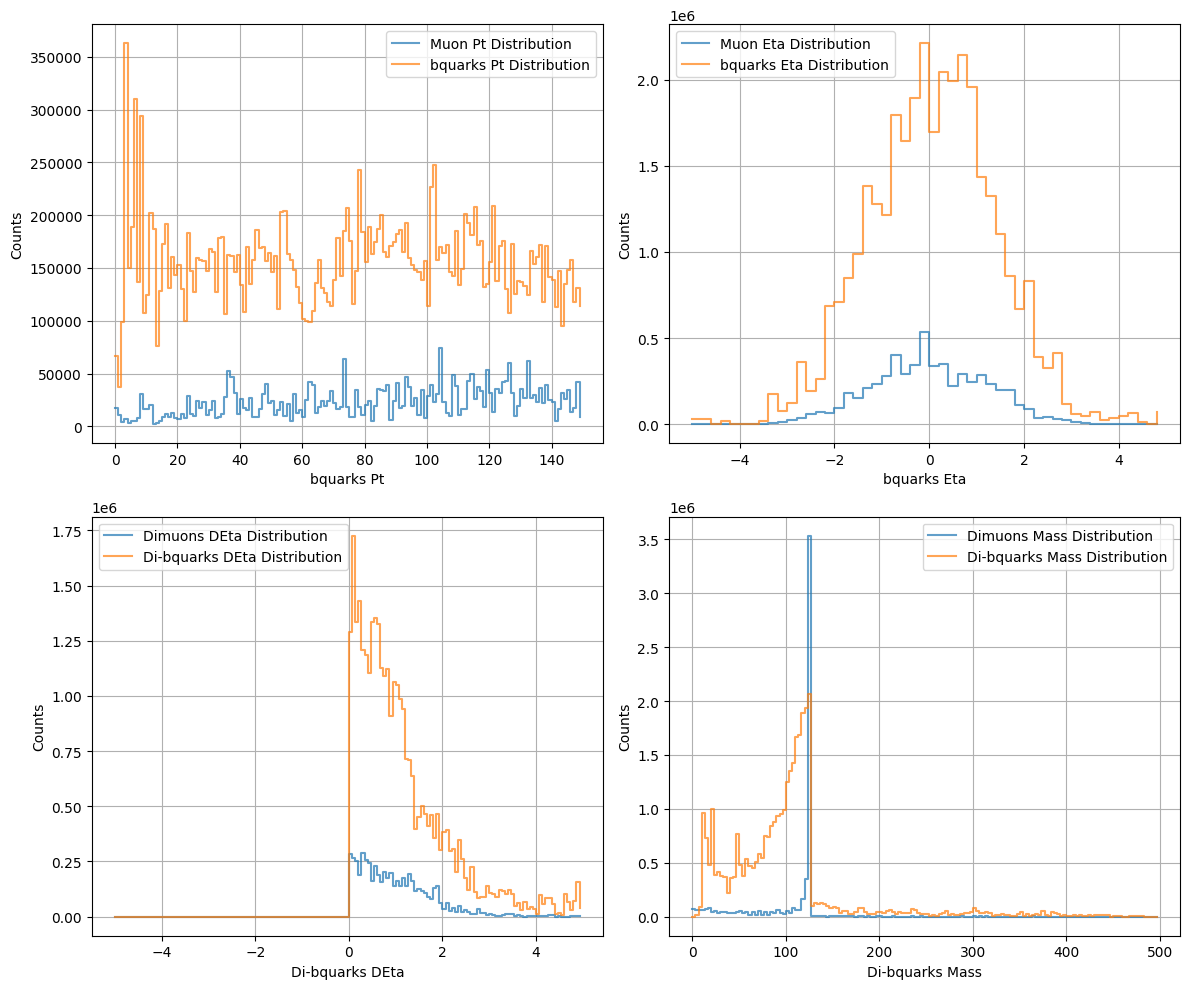

<Figure size 640x480 with 0 Axes>

In [56]:
start = time.time()
    
# Abrir o arquivo ROOT e verificar as keys
#file = uproot.open("pythia_events.root")
#print(file.keys())

# Transferir os eventos do arquivo para awkward arrays
#tree = file["events"]
#events= tree.arrays(library="ak")

# Get directly Root tree named Events
tree = uproot.open("output.root")["events"]
#print("Tree keys ---->" , tree.keys() )
tree.show()

# get Tree data into AWK arrays
events= tree.arrays(library="ak")

# Create the particles array collection in each event 
particles = ak.zip({"px": events.px, 
                    "py": events.py, 
                    "pz": events.pz, 
                    "e": events.E, 
                    "pt": events.pt, 
                    "eta": events.eta, 
                    #"phi": events.eta, 
                    "id": events.id, 
                    "charge": np.sign(events.id),
                    }, 
                    with_name="particle")

print(" ")
print("Particles array:")
particles.type.show()



# Criar histogramas
histograms = create_histograms()

# Filtrar partículas
muons   = particles[np.abs(particles.id) == 13]
bquarks = particles[np.abs(particles.id) == 5] 
print("muons charge ---> ",muons.charge)
print("bquarks charge ---> ",bquarks.charge)

if len(muons) >= 2:

    # Combinar muons com carga total = zero
    combs = ak.combinations(muons, 2,fields=["mu1","mu2"] )
    mupair = combs[ (combs["mu1"].charge + combs["mu2"].charge) == 0 ]
    print("mu 1 pairs --->", mupair["mu1"].charge)
    print("mu 2 pairs --->", mupair["mu2"].charge)

    for pair in mupair:
        pt_mumu  = pt( (mupair["mu1"].px + mupair["mu2"].px) , (mupair["mu1"].py + mupair["mu2"].py ))
        eta_mumu = eta((mupair["mu1"].px + mupair["mu2"].px) ,
                       (mupair["mu1"].py + mupair["mu2"].py) ,
                       (mupair["mu1"].pz + mupair["mu2"].pz) ,
                       (mupair["mu1"].e + mupair["mu2"].e) )
        
        deta_mumu = np.abs( mupair["mu1"].eta - mupair["mu2"].eta )
        mass_mumu = mass((mupair["mu1"].px + mupair["mu2"].px) ,
                         (mupair["mu1"].py + mupair["mu2"].py) ,
                         (mupair["mu1"].pz + mupair["mu2"].pz) ,
                         (mupair["mu1"].e + mupair["mu2"].e) )
        
        # Preencher histogramas
        histograms["hist_mumu_pt"].fill(ak.flatten(pt_mumu))
        histograms["hist_mumu_eta"].fill(ak.flatten(eta_mumu))
        histograms["hist_mumu_deta"].fill(ak.flatten(deta_mumu))
        histograms["hist_mumu_mass"].fill(ak.flatten(mass_mumu))
if len(muons) >= 2:

    # Combinar bquarks com carga total = zero
    combsb = ak.combinations(bquarks, 2,fields=["b1","b2"] )
    bquarkspair = combsb[ (combsb["b1"].charge + combsb["b2"].charge) == 0 ]
    print("b 1 pairs --->", bquarkspair["b1"].charge)
    print("b 2 pairs --->", bquarkspair["b2"].charge)

    for pairb in bquarkspair:
        pt_bb  = pt( (bquarkspair["b1"].px + bquarkspair["b2"].px) , (bquarkspair["b1"].py + bquarkspair["b2"].py ))
        eta_bb = eta((bquarkspair["b1"].px + bquarkspair["b2"].px) ,
                       (bquarkspair["b1"].py + bquarkspair["b2"].py) ,
                       (bquarkspair["b1"].pz + bquarkspair["b2"].pz) ,
                       (bquarkspair["b1"].e + bquarkspair["b2"].e) )
        
        deta_bb = np.abs( bquarkspair["b1"].eta - bquarkspair["b2"].eta )
        mass_bb = mass((bquarkspair["b1"].px + bquarkspair["b2"].px) ,
                         (bquarkspair["b1"].py + bquarkspair["b2"].py) ,
                         (bquarkspair["b1"].pz + bquarkspair["b2"].pz) ,
                         (bquarkspair["b1"].e + bquarkspair["b2"].e) )
        
        # Preencher histogramas
        histograms["hist_bb_pt"].fill(ak.flatten(pt_bb))
        histograms["hist_bb_eta"].fill(ak.flatten(eta_bb))
        histograms["hist_bb_deta"].fill(ak.flatten(deta_bb))
        histograms["hist_bb_mass"].fill(ak.flatten(mass_bb))

print(f"Time to run: {(time.time() - start)} seconds")

# Plotar os histogramas
fig, ax = plt.subplots(2, 2, figsize=(12, 10))

# Histogramas de muons
plot_hist(ax[0, 0], histograms["hist_mumu_pt"], 'Muons Pt', 'Counts', 'Muon Pt Distribution')
plot_hist(ax[0, 1], histograms["hist_mumu_eta"], 'Muons Eta', 'Counts', 'Muon Eta Distribution')
plot_hist(ax[1, 0], histograms["hist_mumu_deta"], 'Dimuons DEta', 'Counts', 'Dimuons DEta Distribution')
plot_hist(ax[1, 1], histograms["hist_mumu_mass"], 'Dimuons Mass', 'Counts', 'Dimuons Mass Distribution')
# Histogramas de bquarks
plot_hist(ax[0, 0], histograms["hist_bb_pt"], 'bquarks Pt', 'Counts', 'bquarks Pt Distribution')
plot_hist(ax[0, 1], histograms["hist_bb_eta"], 'bquarks Eta', 'Counts', 'bquarks Eta Distribution')
plot_hist(ax[1, 0], histograms["hist_bb_deta"], 'Di-bquarks DEta', 'Counts', 'Di-bquarks DEta Distribution')
plot_hist(ax[1, 1], histograms["hist_bb_mass"], 'Di-bquarks Mass', 'Counts', 'Di-bquarks Mass Distribution')


plt.tight_layout()
plt.show()


plt.tight_layout()

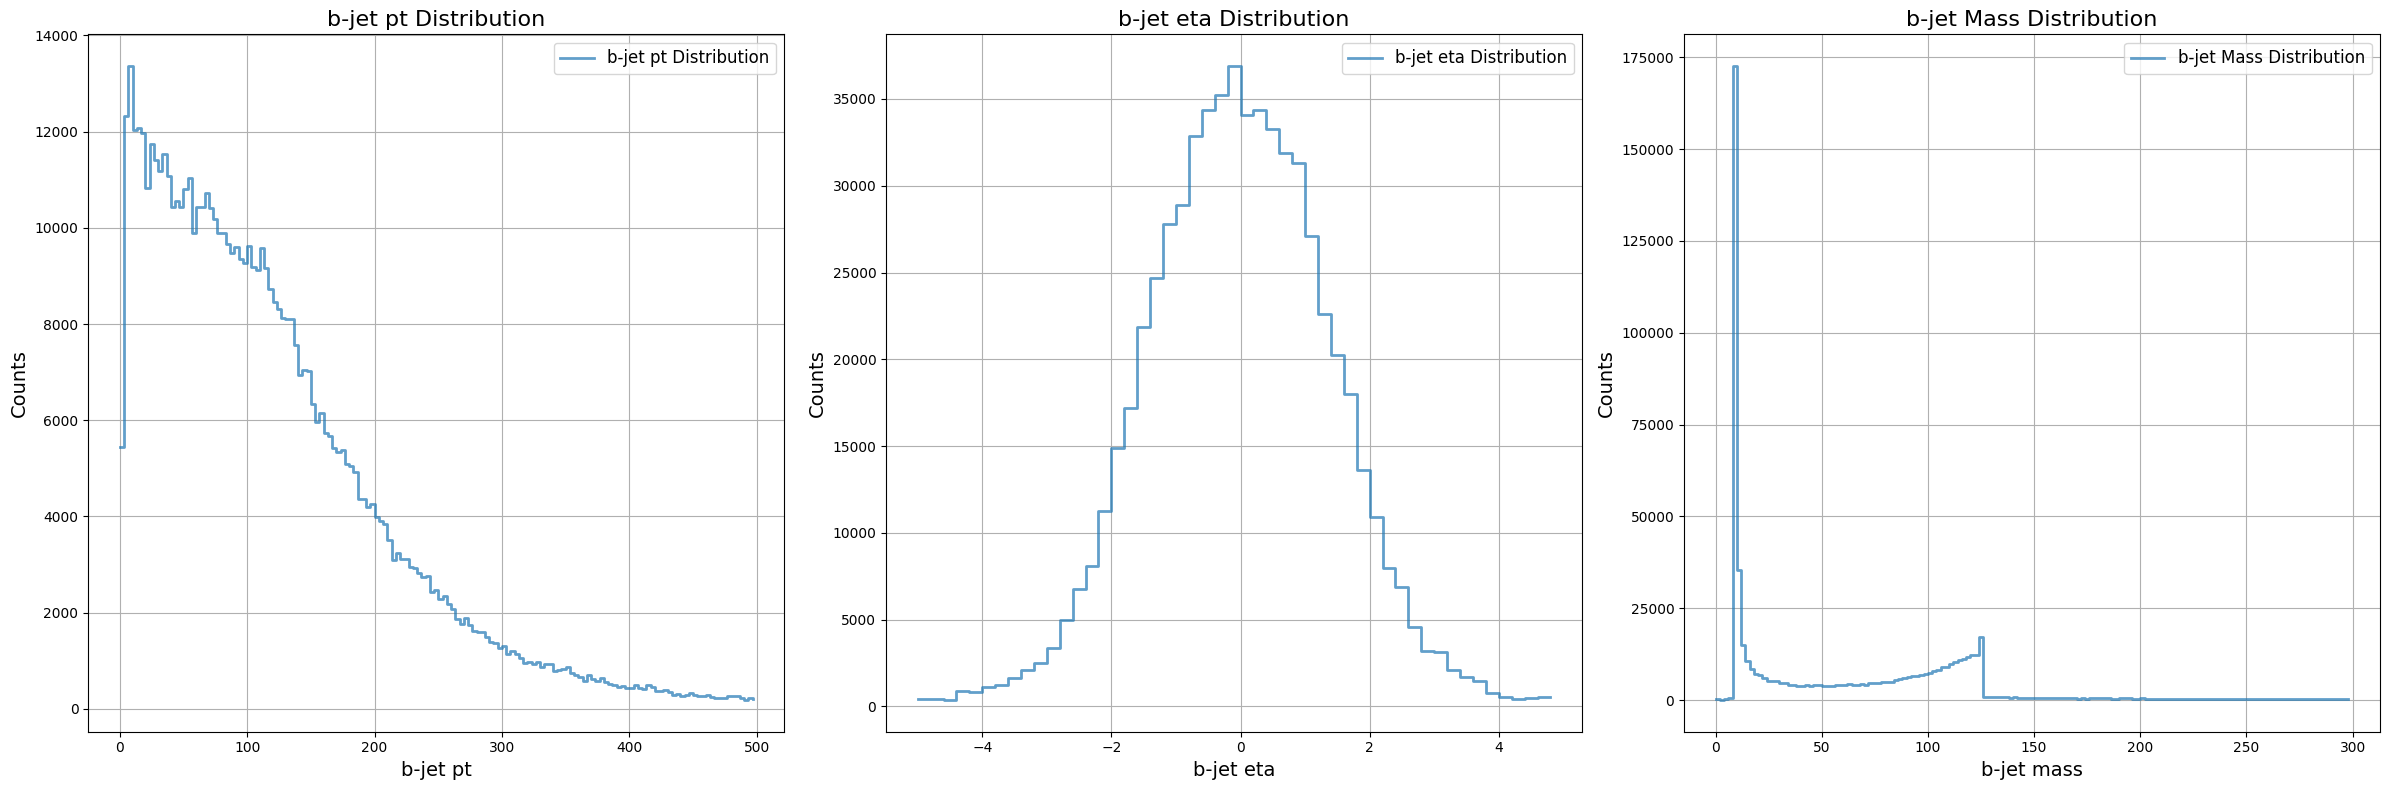

In [29]:
import uproot
import numpy as np
import awkward as ak
import hist
import matplotlib.pyplot as plt

# Funções para cálculos básicos
def pt(px, py):
    return np.sqrt(px**2 + py**2)

def eta(px, py, pz, e):
    p = np.sqrt(px**2 + py**2 + pz**2)
    return 0.5 * np.log((e + pz) / (e - pz))

def mass(px, py, pz, e):
    return np.sqrt(e**2 - (px**2 + py**2 + pz**2))

# Carregar o arquivo .root
file = uproot.open("events4.root")
tree = file["Events"]
events = tree.arrays(library="ak")

# Carregar partículas
particles = ak.zip({"px": events.px, "py": events.py, "pz": events.pz, "e": events.energy, 
                    "pt": events.pt, "eta": events.eta, "phi": events.phi, "id": events.pdgId, 
                    "charge": events.charge, "status": events.status}, 
                    with_name="particle")

# Filtrar b-quarks
bquarks = particles[np.abs(particles.id) == 5]

# Reconstruir vértices secundários para b-quarks
secondary_vertices = ak.combinations(bquarks, 2, fields=["b1", "b2"])
sv_mass = mass(secondary_vertices["b1"].px + secondary_vertices["b2"].px,
               secondary_vertices["b1"].py + secondary_vertices["b2"].py,
               secondary_vertices["b1"].pz + secondary_vertices["b2"].pz,
               secondary_vertices["b1"].e + secondary_vertices["b2"].e)

# Filtrar vértices secundários com base em critérios, como massa (exemplo)
sv_filtered = secondary_vertices[sv_mass > 2.0]  # Ajuste o corte conforme necessário

# Calcular pt e eta para os vértices filtrados
pt_bb = pt(sv_filtered["b1"].px + sv_filtered["b2"].px, sv_filtered["b1"].py + sv_filtered["b2"].py)
eta_bb = eta(sv_filtered["b1"].px + sv_filtered["b2"].px, sv_filtered["b1"].py + sv_filtered["b2"].py,
             sv_filtered["b1"].pz + sv_filtered["b2"].pz, sv_filtered["b1"].e + sv_filtered["b2"].e)

# Converter para numpy arrays e achatar os arrays
pt_bb = ak.to_numpy(ak.flatten(pt_bb))
eta_bb = ak.to_numpy(ak.flatten(eta_bb))
sv_mass = ak.to_numpy(ak.flatten(sv_mass))

# Criar histogramas para os b-jatos identificados
histograms = {
    "hist_bb_pt": hist.Hist.new.Reg(150, 0, 500).Int64(),
    "hist_bb_eta": hist.Hist.new.Reg(50, -5, 5).Int64(),
    "hist_bb_mass": hist.Hist.new.Reg(150, 0, 300).Int64()
}

# Preencher histogramas com os valores convertidos para numpy arrays
histograms["hist_bb_pt"].fill(pt_bb)
histograms["hist_bb_eta"].fill(eta_bb)
histograms["hist_bb_mass"].fill(sv_mass)

# Função para plotar histogramas com ajustes de estilo
def plot_hist(ax, hist_obj, xlabel, ylabel, title):
    edges = hist_obj.axes[0].edges
    values = hist_obj.values()
    ax.step(edges[:-1], values, where='post', alpha=0.7, linewidth=2, label=title)
    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(fontsize=12)
    ax.grid(True)

# Aumentar o tamanho da figura para melhor visualização
fig, ax = plt.subplots(1, 3, figsize=(24, 8))

# Plots com legendas maiores e mais espessura de linha para melhorar a visualização
plot_hist(ax[0], histograms["hist_bb_pt"], 'b-jet pt', 'Counts', 'b-jet pt Distribution')
plot_hist(ax[1], histograms["hist_bb_eta"], 'b-jet eta', 'Counts', 'b-jet eta Distribution')
plot_hist(ax[2], histograms["hist_bb_mass"], 'b-jet mass', 'Counts', 'b-jet Mass Distribution')

plt.tight_layout()
plt.show()
